In [1]:
import requests
import tensorflow as tf
from keras.models import model_from_json
import pandas as pd
import json
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt

import os

import urllib
import random
import math
import time
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, Normalizer, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.externals.joblib import dump, load
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
import pickle
from sklearn.externals import joblib
import tensorflow as tf
import keras
from keras import initializers
from sklearn.preprocessing import StandardScaler

# cfg = tf.ConfigProto(allow_soft_placement=True )
# cfg.gpu_options.allow_growth = True
# plt.rcParams['agg.path.chunksize'] = 10000

from scipy.signal import savgol_filter as savitzky_golay
import scipy.signal

np.random.seed(1)
tf.set_random_seed(1)
import datetime
import pyarrow


Using TensorFlow backend.


In [2]:
model_dir = '/media/kevinpeng/cdrive/Users/kevin.peng/code/Depthshift_Depthjump_corrected/Newdata/DepthLogs_cartesian_new/result'

In [3]:
csvfile = f"{model_dir}/onewell_1511307991_2019_09_19_13_06_14.csv"
df = pd.read_csv(csvfile,  
                 encoding='latin-1', error_bad_lines=False, lineterminator='\n')


In [4]:
data_columns = list(df.columns)
sg_cols = ['actual_rop', 'Weight_on_Bit__klbs_' ,'Gamma__api_','Differential_Pressure__psi_','d_mse','Standpipe_Pressure__psi_','Total_Pump_Output__gal_per_min_'] 

dropcolumns = ['msc_sync','UWI','UWI_x','UWI_y', 'd_mse','rop_sg','Rate_Of_Penetration__ft_per_hr_','actual_rop','well_id','hole_depth','section'
               ,'Hole_Depth__feet_','index', 'UWI', 'FILE_ID',
              'actual_ropsg','Rate_Of_Penetration__ft_per_hr_sg','Differential_Pressure__psi_','section_Surface',
              'Convertible_Torque__kft_lb_','Convertible_Torque__kft_lb_sg','d_msesg', 'On_Bottom_Hours__hrs_',
               'Standpipe_Pressure__psi_' ,'bha_bendAngle','MM_TorqF', 'MM_rpmF','Total_Pump_Output__gal_per_min_',
              
               'bha_bendToThirdContactPoint', 'bha_buildRate','Depth',
               'rateTurn','rateBuild',
              
               'fluidtype',  'viscosity','density','gel_factor', 'spg_factor', 'yp_factor',
              
               'AreaNozzleFlow','log_msesg',
               'x','y','z', 'Unnamed: 0'
              ]

#'bha_bendAngle', 'bha_bendToThirdContactPoint', 'bha_buildRate',


dropcolumns += sg_cols
data_columns = [col  for col in list(df.columns) if col not in dropcolumns]
print(data_columns)
print(len(data_columns))

['Rotary_RPM__RPM_', 'numeric_activity', 'Inclination__degrees_', 'Azimuth__degrees_', 'Diameterbit', 'gl_tvd', 'y_lat', 'x_long', 'z_kb_tvd', 'section_Curve', 'section_Intermediate', 'section_Intermediate2', 'section_Lateral', 'bha_type_FullyStabilized', 'bha_type_PartiallyStabilized', 'bha_type_Slick', 'i_cos', 'a_cos', 'i_sin', 'a_sin', 'Weight_on_Bit__klbs_sg', 'Gamma__api_sg', 'Differential_Pressure__psi_sg', 'Standpipe_Pressure__psi_sg', 'Total_Pump_Output__gal_per_min_sg']
25


In [5]:
data = df[data_columns].values

In [6]:
scaler = joblib.load(model_dir+'/model_ann_full__2019_09_20_10_08_11_std_scaler.bin') 
data =  scaler.transform(data)


In [8]:
endpoint = "http://127.0.0.1:5000"
json_data = {"model_name": "default", "data": {"input_image":data.astype('float16').tolist()}}
with open('input.json', 'w') as outfile:
    json.dump(json_data, outfile)
result = requests.post(endpoint, json=json_data)
# print(result.json())

In [9]:
y_hat = np.array(list(result.json().values())[0]).flatten()*230

In [10]:
def sgfilter(df, col, window, pol):
    dfs = {}
    for well in wellids:
        dfs[well] = df[df.well_id==well]
        dfs[well][col+"sg"] = savitzky_golay(dfs[well][col],window,pol)
    df = pd.concat(dfs.values())

    return df

print ("sg_definition")

sg_definition


In [11]:
test_ypred = savitzky_golay(y_hat, 2001, 2)

In [12]:
test_y = df['actual_ropsg'].values

In [13]:
# MAX_ROP=230
# test_ypred = (1-y_hat)*230
test_y = test_y
print(f'Test set {csvfile} ')
print(r2_score(test_y,test_ypred))
print(mean_squared_error(test_y,test_ypred))
print(mean_absolute_error(test_y,test_ypred))

Test set /media/kevinpeng/cdrive/Users/kevin.peng/code/Depthshift_Depthjump_corrected/Newdata/DepthLogs_cartesian_new/result/onewell_1511307991_2019_09_19_13_06_14.csv 
0.8967896529085669
115.1517376838804
7.88774749007312


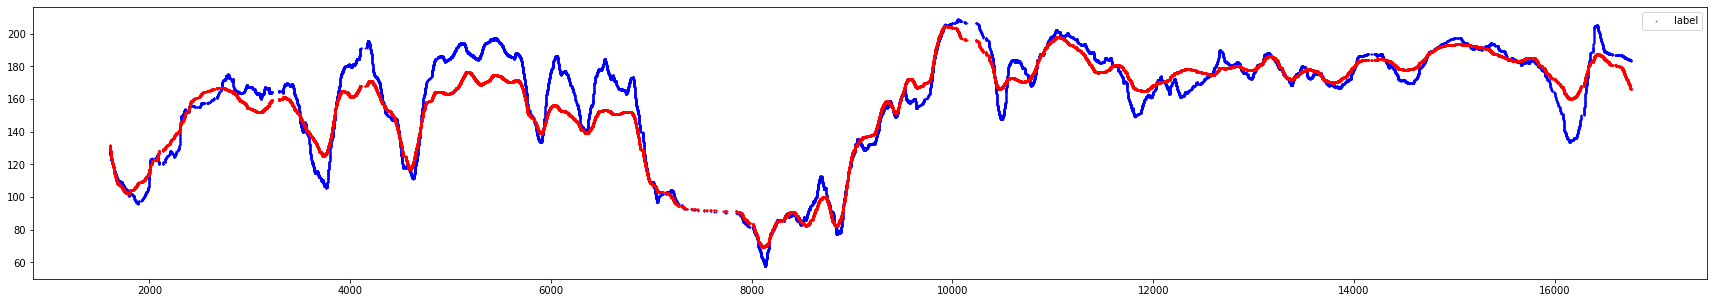

In [15]:
depth = df['Hole_Depth__feet_'].values
plt.figure(num=None, figsize=(30, 5), facecolor='w', edgecolor='k')
plt.scatter(depth, test_y, 1, 'b', label='label', alpha = 0.4)
plt.scatter(depth, test_ypred, 1, 'r')

plt.legend()
plt.show()